In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LeakyReLU, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [2]:
#df1 = pd.read_csv('newer_trades.csv')
#df2 = pd.read_csv('recent_eth_prices.csv')
#df3 = pd.read_csv('model_data.csv')
#df = pd.concat([df2, df3], ignore_index=True)
#df = df.sort_values('time')
#df.to_csv('model_data.csv')
df = pd.read_csv('model_data.csv')

In [3]:
df

,Unnamed: 0.49,Unnamed: 0,trade_id,product_id,price,size,time,side,exchange,bid,...,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1
0,141253,60305,590641283,ETH-USD,3598.16,0.013755,2025-01-04 06:38:20.767435+00:00,SELL,NaN,NaN,...,36308.0,36308.0,36308.0,36308.0,36308.0,36308.0,227275.0,227275.0,143784.0,60293.0
1,141254,60304,590641310,ETH-USD,3598.95,0.002479,2025-01-04 06:38:35.543964+00:00,SELL,NaN,NaN,...,36309.0,36309.0,36309.0,36309.0,36309.0,36309.0,227274.0,227274.0,143783.0,60292.0
2,141255,60303,590641344,ETH-USD,3598.15,3.565571,2025-01-04 06:38:55.779501+00:00,BUY,NaN,NaN,...,36310.0,36310.0,36310.0,36310.0,36310.0,36310.0,227273.0,227273.0,143782.0,60291.0
3,141256,60302,590641361,ETH-USD,3597.71,0.000987,2025-01-04 06:39:14.353069+00:00,BUY,NaN,NaN,...,36311.0,36311.0,36311.0,36311.0,36311.0,36311.0,227272.0,227272.0,143781.0,60290.0
4,141257,60301,590641382,ETH-USD,3597.72,0.200000,2025-01-04 06:39:29.902680+00:00,SELL,NaN,NaN,...,36312.0,36312.0,36312.0,36312.0,36312.0,36312.0,227271.0,227271.0,143780.0,60289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318862,141248,141312,622994413,ETH-USD,1912.71,0.003351,2025-03-13 00:24:19.882572+00:00,BUY,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1318863,141249,141313,622994457,ETH-USD,1912.02,0.026370,2025-03-13 00:24:34.173855+00:00,BUY,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1318864,141250,141314,622994502,ETH-USD,1911.52,0.005228,2025-03-13 00:24:50.744690+00:00,SELL,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1318865,141251,141315,622994556,ETH-USD,1911.41,0.002589,2025-03-13 00:25:06.144852+00:00,SELL,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#drop unneeded columns
columns_to_drop = ['Unnamed: 0', 'exchange', 'bid', 'ask', 'trades', 'best_bid', 'best_ask', 'trade_id', 'product_id']

# Check for existing columns before dropping to avoid KeyErrors
df_trades = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

In [5]:
#change side column to SELL = 0 and BUY = 1
df_trades['side'] = df_trades['side'].map({'SELL': 0, 'BUY': 1})
df_trades

,Unnamed: 0.49,price,size,time,side,Unnamed: 0.48,Unnamed: 0.47,Unnamed: 0.46,Unnamed: 0.45,Unnamed: 0.44,...,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1
0,141253,3598.16,0.013755,2025-01-04 06:38:20.767435+00:00,0.0,23384.0,60490.0,60490.0,60490.0,60490.0,...,36308.0,36308.0,36308.0,36308.0,36308.0,36308.0,227275.0,227275.0,143784.0,60293.0
1,141254,3598.95,0.002479,2025-01-04 06:38:35.543964+00:00,0.0,23385.0,60491.0,60491.0,60491.0,60491.0,...,36309.0,36309.0,36309.0,36309.0,36309.0,36309.0,227274.0,227274.0,143783.0,60292.0
2,141255,3598.15,3.565571,2025-01-04 06:38:55.779501+00:00,1.0,23386.0,60492.0,60492.0,60492.0,60492.0,...,36310.0,36310.0,36310.0,36310.0,36310.0,36310.0,227273.0,227273.0,143782.0,60291.0
3,141256,3597.71,0.000987,2025-01-04 06:39:14.353069+00:00,1.0,23387.0,60493.0,60493.0,60493.0,60493.0,...,36311.0,36311.0,36311.0,36311.0,36311.0,36311.0,227272.0,227272.0,143781.0,60290.0
4,141257,3597.72,0.200000,2025-01-04 06:39:29.902680+00:00,0.0,23388.0,60494.0,60494.0,60494.0,60494.0,...,36312.0,36312.0,36312.0,36312.0,36312.0,36312.0,227271.0,227271.0,143780.0,60289.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1318862,141248,1912.71,0.003351,2025-03-13 00:24:19.882572+00:00,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1318863,141249,1912.02,0.026370,2025-03-13 00:24:34.173855+00:00,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1318864,141250,1911.52,0.005228,2025-03-13 00:24:50.744690+00:00,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1318865,141251,1911.41,0.002589,2025-03-13 00:25:06.144852+00:00,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


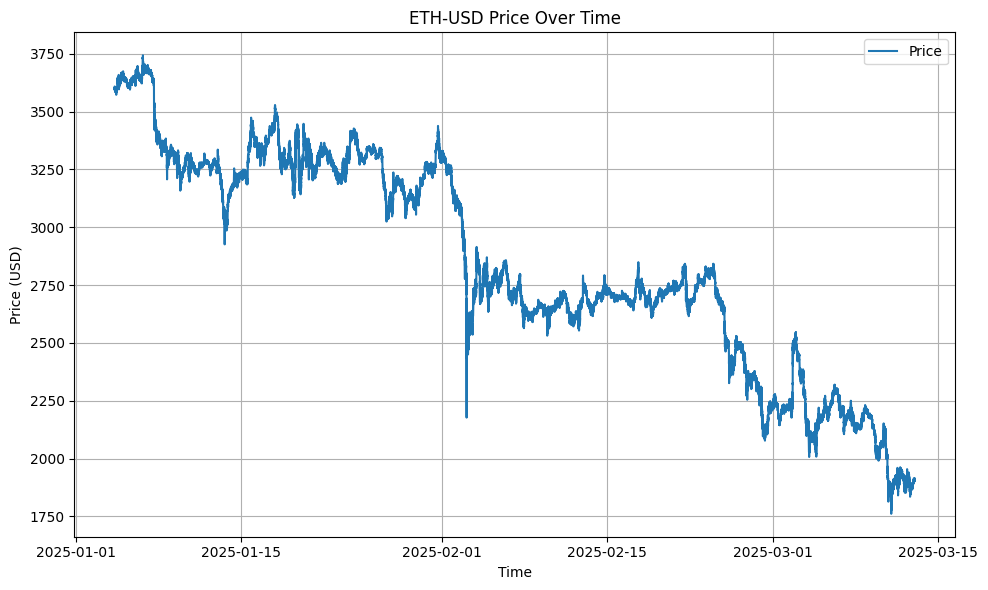

In [6]:
# Convert 'time' to datetime, coercing errors
df_trades['time'] = pd.to_datetime(df_trades['time'], errors='coerce')

# Drop rows where 'time' is NaT (invalid date)
df_trades = df_trades.dropna(subset=['time'])

# Convert 'price' column to numeric
df_trades['price'] = pd.to_numeric(df_trades['price'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_trades['time'], df_trades['price'], linestyle='-', label='Price')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('ETH-USD Price Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
# Ensure time column is sorted
df_trades = df_trades.sort_values('time')

# Scale the 'price' and 'size' column
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = RobustScaler()
df_trades['price_scaled'] = scaler.fit_transform(df_trades[['price']])

# Create sequences of data for LSTM
sequence_length = 10  # Sequence of 10 observations
forecast_steps = 5  # Predict 5 steps into the future

In [8]:
# Compute percent difference
df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage

# Drop the first row since pct_change for first row is NaN
df_trades = df_trades.dropna(subset=['pct_change']).reset_index(drop=True)

df_trades = df_trades.drop(columns=[col for col in df_trades.columns if col.startswith("Unnamed")])

In [9]:
df_trades['sma_5'] = df_trades['price_scaled'].rolling(window=5).mean()
df_trades['momentum'] = df_trades['price_scaled'] - df_trades['price_scaled'].shift(5)
df_trades.dropna(subset=['sma_5', 'momentum'], inplace=True)
df_trades.head()

,price,size,time,side,price_scaled,pct_change,sma_5,momentum
5,3597.69,0.003707,2025-01-04 06:40:00.442719+00:00,1.0,1.482697,-0.000556,1.482878,-0.002157
6,3597.70,0.006879,2025-01-04 06:40:17.994423+00:00,0.0,1.482714,0.000278,1.482724,-0.000770
7,3597.70,0.015755,2025-01-04 06:40:32.624359+00:00,0.0,1.482714,0.000000,1.482721,-0.000017
8,3597.70,0.000804,2025-01-04 06:40:48.741554+00:00,0.0,1.482714,0.000000,1.482714,-0.000034
9,3597.70,0.119900,2025-01-04 06:41:04.481562+00:00,0.0,1.482714,0.000000,1.482711,-0.000017


In [10]:
# split data into sequences and X and y
X = []
y = []

prices = df_trades['price_scaled'].values
sma_5 = df_trades['sma_5'].values
momentum = df_trades['momentum'].values
pct_change = df_trades['pct_change'].values

for i in range(len(prices) - sequence_length - forecast_steps):
    #build feature set
    row = []
    row.append(prices[i:i + sequence_length])
    row.append(sma_5[i:i + sequence_length])
    row.append(momentum[i:i + sequence_length])

    #X.append(prices[i:i + sequence_length])
    X.append(row)
    y.append(prices [i + sequence_length + forecast_steps - 1])

X = np.array(X)
y = np.array(y)

# Reshape X for LSTM input (samples, time steps, features)
#X = X.reshape(X.shape[0], X.shape[1], 1)

In [11]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
X_train.shape

(1055076, 3, 10)

In [13]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),

    LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    LSTM(128, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    LSTM(64, activation='relu', return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(128, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.3),

    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.3),

    Dense(1)
])

model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 128)         │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,385 (1.53 MB)

 Trainable params: 400,385 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 424s 13ms/step - loss: 0.0857 - val_loss: 0.2192
Epoch 2/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 740s 22ms/step - loss: 0.0053 - val_loss: 0.2168
Epoch 3/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 3241s 98ms/step - loss: 0.0041 - val_loss: 0.2094
Epoch 4/100
32972/32972 ━━━━━━━━━━━━━━━━━━━━ 330s 10ms/step - loss: 0.0035 - val_loss: 0.2099
Epoch 5/100
 2965/32972 ━━━━━━━━━━━━━━━━━━━━ 5:14 10ms/step - loss: 0.0033

KeyboardInterrupt: 

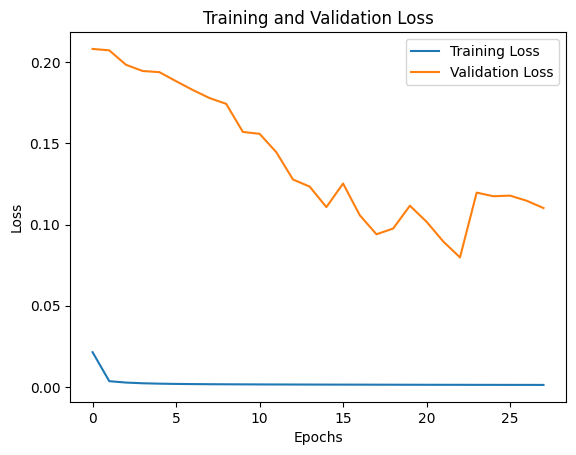

In [33]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
#save model to h5 format because mac M1 is silly
model.save("models/lstm_eth_model.keras")
#save model to convert to ONNX model later
model.export("models/model")

INFO:tensorflow:Assets written to: models/model/assets


INFO:tensorflow:Assets written to: models/model/assets


Saved artifact at 'models/model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3, 10), dtype=tf.float32, name='keras_tensor_12')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  14589979600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14589978832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14742402256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14742402064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14742401872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14742403792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14742403600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14742402832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14742403024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14742402448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14742404944: TensorSpec(shape=(), dtype=tf.resource, name=Non

In [35]:
# Make predictions on the test set
predictions_scaled = model.predict(X_test)

# Inverse transform the predictions and test labels to get original prices
predictions = scaler.inverse_transform(predictions_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

8243/8243 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step


In [36]:
model.get_metrics_result()

{'loss': 0.11014003306627274}

In [37]:
predictions_scaled[1]

array([-0.10481313], dtype=float32)

In [38]:
y_test[10]

-0.09654244529689383

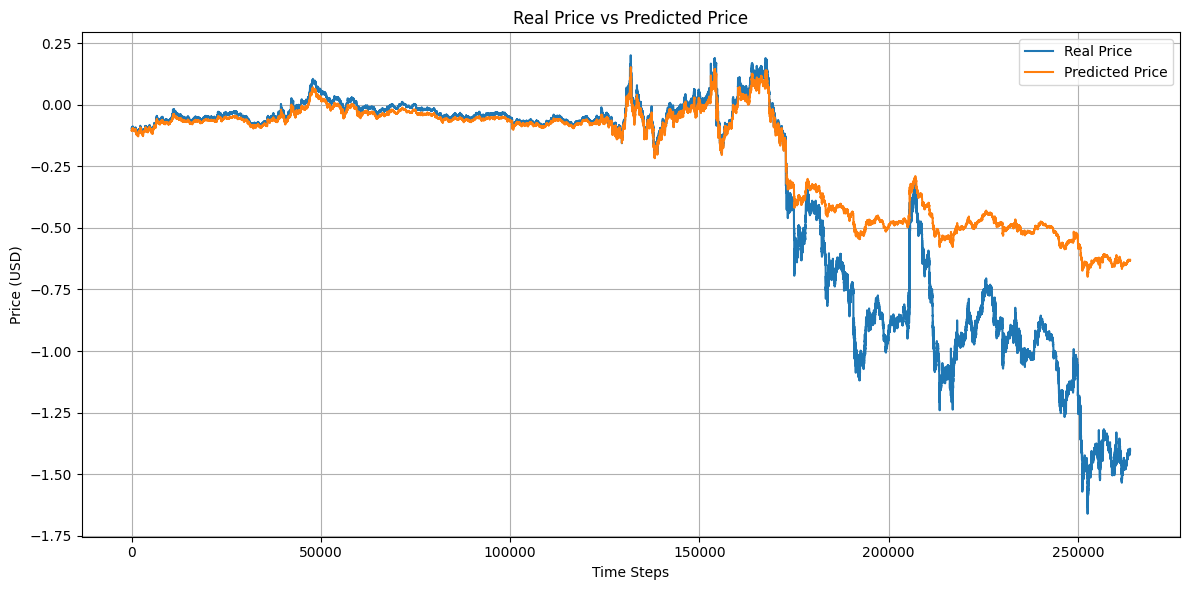

In [39]:
# Plot the real vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Real Price", linestyle='-')
plt.plot(predictions, label="Predicted Price", linestyle='-')
plt.title("Real Price vs Predicted Price")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()